This notebook is based on https://github.com/stelais/jasmine/blob/main/src/jasmine/rtmodel_pylima_mcmc/ (a code from Stela Ishitani Silva and Jon Hulberg) and https://github.com/ebachelet/pyLIMA/blob/master/examples/pyLIMA_example_1.ipynb (a code from the pyLIMA authors, Bachelet et al. 2017).

In [3]:
# Imports
import os
import csv
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.units as u

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.models import FSBL_model
from pyLIMA.fits import MCMC_fit
from pyLIMA.models import pyLIMA_fancy_parameters
from pyLIMA.outputs import pyLIMA_plots

from multiprocessing import Pool

# Running a pyLIMA MCMC

In [6]:
def run_pylima_mcmc_for_ls(general_path_for_rtmodel_run_,
                           rtmodel_parameters_,
                           number_of_processors_=os.cpu_count()):
    data_folder_path = f'{general_path_for_rtmodel_run_}/Data'

    #======================================================
    #               Creating the event + loading data
    #======================================================
    # Convert coordinates to decimal degrees to pyLIMA format
    file_path = f'{data_folder_path}/event.coordinates'
    event_coordinates = pd.read_csv(file_path, sep=r'\s+', header=None, names=['RA_HMS', 'Dec_DMS'])
    # Convert RA and Dec to decimal degrees
    coord = SkyCoord(ra=event_coordinates['RA_HMS'].iloc[0], dec=event_coordinates['Dec_DMS'].iloc[0],
                     unit=(u.hourangle, u.deg))
    ra_deg, dec_deg = coord.ra.deg, coord.dec.deg

    # Create a pyLIMA event object
    your_event = event.Event(ra=ra_deg, dec=dec_deg)
    your_event.name = f'mb20135'

    # Load up the data from the RTModel folder
    print('Loading data...')
    names = ['instrument', 'HJD', 'flux', 'err', 'satellite']
    lc_to_fit = pd.read_csv(f'{general_path_for_rtmodel_run_}/LCToFit.txt', names=names, sep=r'\s+', skiprows=1)
    lc_to_fit['HJD'] += 2_450_000  # pylima wants hjd not hjd - 2450000
    filters = []
    with open(f'{general_path_for_rtmodel_run_}/FilterToData.txt', 'r') as f:
        for line in f:
            s = line.strip('\n')
            filters.append(s)
    ald_coefficients = []
    with open(f'{general_path_for_rtmodel_run_}/Data/LimbDarkening.txt', 'r') as f:
        for line in f:
            s = float(line.strip('\n'))
            ald_coefficients.append(s)

    # Splitting the lighcurves by instrument
    cfhti_lc = lc_to_fit[lc_to_fit['instrument'] == 0]
    moa2V_lc = lc_to_fit[lc_to_fit['instrument'] == 1]
    moa2r_lc = lc_to_fit[lc_to_fit['instrument'] == 2]


    # Create the telescope objects
    telescope_0 = telescopes.Telescope(name='cfht-i',
                                       camera_filter='i',
                                       lightcurve=cfhti_lc[['HJD', 'flux', 'err']].values,
                                       lightcurve_names=['time', 'flux', 'err_flux'],
                                       lightcurve_units=['HJD', 'flux', 'flux'])
    telescope_1 = telescopes.Telescope(name='MOA-V',
                                       camera_filter='V',
                                       lightcurve=moa2V_lc[['HJD', 'flux', 'err']].values,
                                       lightcurve_names=['time', 'flux', 'err_flux'],
                                       lightcurve_units=['HJD', 'flux', 'flux'])
    telescope_2 = telescopes.Telescope(name='MOA-Red',
                                   camera_filter='Red',
                                   lightcurve=moa2r_lc[['HJD', 'flux', 'err']].values,
                                   lightcurve_names=['time', 'flux', 'err_flux'],
                                   lightcurve_units=['HJD', 'flux', 'flux'])

    # Add limb darkening
    telescope_0.ld_a1 = ald_coefficients[0]
    telescope_1.ld_a1 = ald_coefficients[1]
    telescope_2.ld_a1 = ald_coefficients[2]

    # Append these telescope data sets to your EVENT object.
    print('Appending data...')
    your_event.telescopes.append(telescope_0)
    your_event.telescopes.append(telescope_1)
    your_event.telescopes.append(telescope_2)
    print(telescope_0.name, telescope_0.ld_a1)
    print(telescope_1.name, telescope_1.ld_a1)
    print(telescope_2.name, telescope_2.ld_a1)

    # Define the MOA2r dataset to be used to align all other data sets (most data points)
    print('Defining survey telescope...')
    your_event.find_survey('MOA-Red')

    print('Checking event...')
    your_event.check_event()

    #======================================================
    #                 CHOSE MODEL
    #======================================================
    print('Choosing model...')
    # Choose the model type
    fancy = pyLIMA_fancy_parameters.StandardFancyParameters()
    fsbl_model = FSBL_model.FSBLmodel(your_event, parallax=['None', 0.0],
                                             orbital_motion=['None',0.0],fancy_parameters=fancy)

    #======================================================
    #                     MCMC FIT
    #======================================================
    print('MCMC Fit:')
    my_mcmc_fit = MCMC_fit.MCMCfit(fsbl_model)
    print('Defining guess parameters...')
    # Using the parameters from your best RTModel run to be your first guess
    rtm_t0, rtm_u0, rtm_tE, rtm_rho, rtm_separation, rtm_mass_ratio, rtm_alpha = rtmodel_parameters_
    guess_parameters = np.array([rtm_t0 + 2450000,
                                 rtm_u0,
                                 np.log10(rtm_tE),
                                 np.log10(rtm_rho),
                                 np.log10(rtm_separation),
                                 np.log10(rtm_mass_ratio),
                                 rtm_alpha])
    my_mcmc_fit.model_parameters_guess = guess_parameters
    pool = Pool(processes=number_of_processors_)
    print('MCMC Fiting...')
    my_mcmc_fit.fit(computational_pool=pool)
    print('MCMC Done')
    return my_mcmc_fit, fsbl_model

## [Action need]: Insert the parameters for the best fit from your RTModel run

In [7]:
# your initial guess from RTModel
# Copy the values from the RTModel run with best chi^2
rtm_t0 = 9040.48843
rtm_u0 = 0.03176
rtm_tE = 17.13
rtm_rho = 0.00504
rtm_separation = 1.03165
rtm_mass_ratio = 0.0001419
rtm_alpha = 2.3804

rtmodel_parameters = [rtm_t0, rtm_u0, rtm_tE, rtm_rho, rtm_separation, rtm_mass_ratio, rtm_alpha]

start = time.time()
my_pylima_mcmc, fsbl = run_pylima_mcmc_for_ls('mb20135_RTModel_run',
                                 rtmodel_parameters,
                                 number_of_processors_=14)
finish = time.time()
print('MCMC took', finish - start, f'seconds')

Loading data...
Appending data...
cfht-i 0.509
MOA-V 0.673
MOA-Red 0.5633
Defining survey telescope...
Checking event...
check_event  : Everything looks fine...
Choosing model...
MCMC Fit:


/var/folders/nm/sm02y8852kz9m76ghqtj6vvm0000gn/T/ipykernel_56146/1495012696.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  event_coordinates = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['RA_HMS', 'Dec_DMS'])


Defining guess parameters...
MCMC Fiting...
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2459040.48843, 0.03176, 1.2337573629655105, -2.2975694635544746, 0.01353238251385762, -3.848017604542526, 2.3804]


100%|██████████| 5000/5000 [10:33<00:00,  7.90it/s]


fit  : Monte Carlo Markov Chain (Affine Invariant) fit SUCCESS
best model:
OrderedDict([('t0', np.float64(2459040.488757625)),
             ('u0', np.float64(0.032982285562665546)),
             ('log_tE', np.float64(1.2208068829789123)),
             ('log_rho', np.float64(-2.3170221808063847)),
             ('log_separation', np.float64(0.013535674802983044)),
             ('log_mass_ratio', np.float64(-3.871040603775084)),
             ('alpha', np.float64(2.3742302236960424)),
             ('fsource_MOA-Red', np.float64(1.297610499694263e-05)),
             ('fblend_MOA-Red', np.float64(1.646597833181077e-05)),
             ('fsource_cfht-i', np.float64(1.749923584966993e-08)),
             ('fblend_cfht-i', np.float64(-5.116105205463828e-09)),
             ('fsource_MOA-V', np.float64(3.067180672925159e-06)),
             ('fblend_MOA-V', np.float64(1.270818225639215e-05)),
             ('tE', np.float64(16.626731478005926)),
             ('rho', np.float64(0.004819231836402605)),

# Results

In [8]:
# Best Model
print(list(my_pylima_mcmc.model.model_dictionnary.keys()))
print('Best model: ', my_pylima_mcmc.fit_results['best_model'])

['t0', 'u0', 'log_tE', 'log_rho', 'log_separation', 'log_mass_ratio', 'alpha', 'fsource_MOA-Red', 'fblend_MOA-Red', 'fsource_cfht-i', 'fblend_cfht-i', 'fsource_MOA-V', 'fblend_MOA-V']
Best model:  [ 2.45904049e+06  3.29822856e-02  1.22080688e+00 -2.31702218e+00
  1.35356748e-02 -3.87104060e+00  2.37423022e+00  1.29761050e-05
  1.64659783e-05  1.74992358e-08 -5.11610521e-09  3.06718067e-06
  1.27081823e-05]


In [17]:
event_name = my_pylima_mcmc.model.event.name
ra = my_pylima_mcmc.model.event.ra
dec = my_pylima_mcmc.model.event.dec
east = my_pylima_mcmc.model.event.East
north = my_pylima_mcmc.model.event.North
parameters_names = list(my_pylima_mcmc.model.model_dictionnary.keys())
best_model_ndarray = my_pylima_mcmc.fit_results['best_model']
fit_time = my_pylima_mcmc.fit_results['fit_time']
MCMC_links = my_pylima_mcmc.MCMC_links
MCMC_walkers = my_pylima_mcmc.MCMC_walkers
MCMC_chains_with_fluxes = my_pylima_mcmc.fit_results['MCMC_chains_with_fluxes']
sampler = my_pylima_mcmc.fit_results['fit_object']

saving_results_path = 'pylima_mcmc'
os.mkdir(saving_results_path)

# Write Best Model in a csv file
print('Saving best model...')
with open(f'{saving_results_path}/mb20135_best_model.csv', 'w',
          newline='') as csvfile1:
    csvfile1.write(f"# Event name: {event_name}\n")
    csvfile1.write(f"# RA: {ra}\n")
    csvfile1.write(f"# Dec: {dec}\n")
    csvfile1.write(f"# East: {east}\n")
    csvfile1.write(f"# North: {north}\n")

    writer = csv.writer(csvfile1)
    # Write header
    writer.writerow(parameters_names)
    # Write data
    writer.writerow(best_model_ndarray)

# Write MCMC chains in a csv file
print('Saving MCMC chains...')
with open(f'{saving_results_path}/mb20135_mcmc_chain.csv', 'w',
          newline='') as csvfile2:
    csvfile2.write(f"# Event name: {event_name}\n")
    csvfile2.write(f"# RA: {ra}\n")
    csvfile2.write(f"# Dec: {dec}\n")
    csvfile2.write(f"# East: {east}\n")
    csvfile2.write(f"# North: {north}\n")
    csvfile2.write(f"# Fit time: {fit_time}\n")
    csvfile2.write(f"# MCMC links: {MCMC_links}\n")
    csvfile2.write(f"# MCMC walkers: {MCMC_walkers}\n")
    csvfile2.write(f'#Autocorr Time = {sampler.get_autocorr_time(tol=0)}\n')
    csvfile2.write(f'#Acceptance Ratio =  {sampler.acceptance_fraction}\n')

    writer = csv.writer(csvfile2)
    # Write header
    writer.writerow(parameters_names + ['likelihood', 'prior'])
    # Write data
    for quoted_arrays in MCMC_chains_with_fluxes:
        for array in quoted_arrays:
            writer.writerow(array)
print('All done!')

Saving best model...
Saving MCMC chains...
All done!


# Plotting

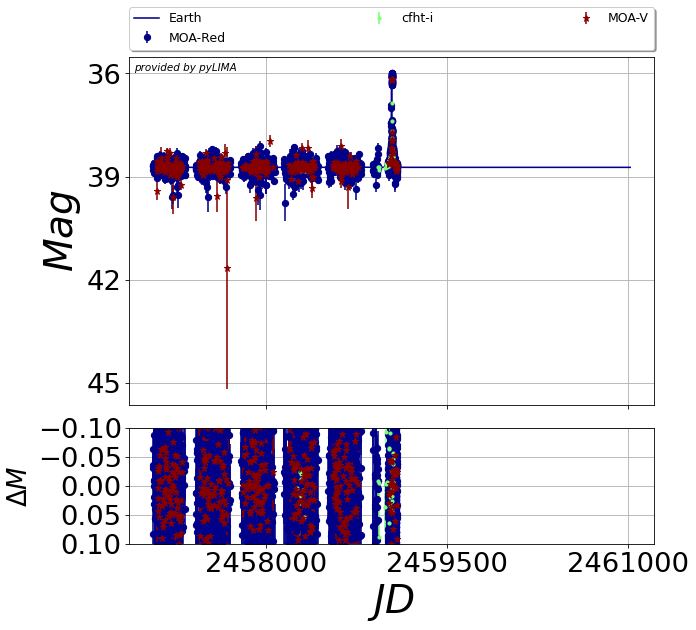

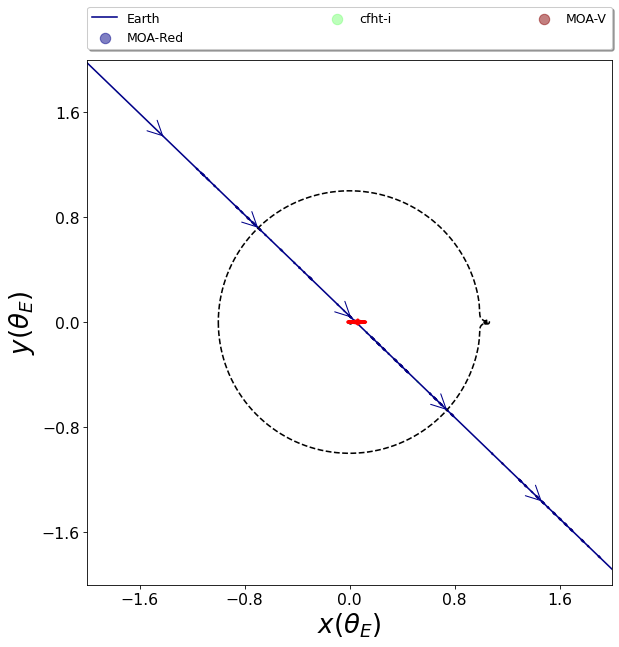

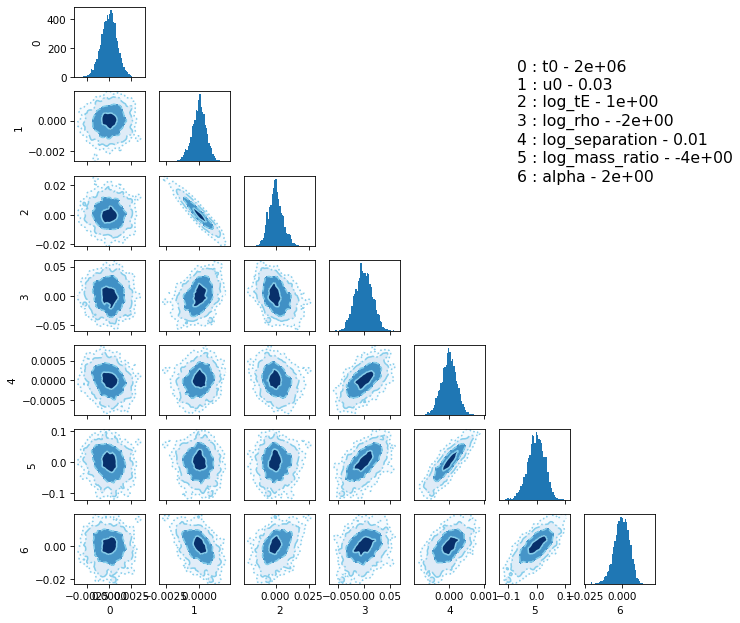

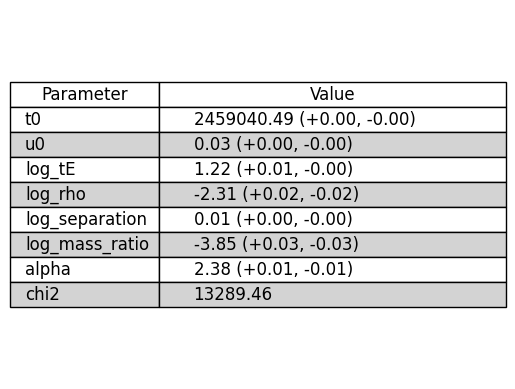

In [39]:
pyLIMA_plots.list_of_fake_telescopes = []
my_pylima_mcmc.fit_outputs()
plt.show()